In [1]:

# %pip install pandas==1.3.5 # for comaparability woth colab
# %pip install levenshtein
# %pip freeze > session_info_sunflower.txt 
#%pip install sentence_transformers==0.3.8 
#%pip install seaborn

In [2]:
import os 
import pickle 
import pandas as pd
import yaml
import sys
from datetime import date
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import math
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

/home/RDC/zinovyee.hub/.conda/envs/quantlet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CONSTANTS
RS = 42

In [4]:
# FUNCTIONS

def key_extr(row:pd.DataFrame) -> str:
    """Extracts keywords field from the metainfo row"""
    try: 
        return row["Keywords"] 
    except: 
        pass
    

def ext_key_meta_str(row:str) -> str:
    """Extracts keywords field from the unparsable metainfo files"""
    row = row.replace('NW: ', '')
    field_list = row.split("\n")
    for field in field_list:
        if ":" not in field:
            continue
        field_name, field_value = field.split(":")[0], field.split(":")[1]
        field_name = field_name.lower()
        field_value = field_value.strip()

        if "keyw" in field_name:
            key = field_value
            return key
        else: 
            continue

In [5]:
with open("../../data/preprocessed/Quantlet/20231104/Quantlets_20231104.pkl", "rb") as file: 
    df = pickle.load(file)

In [6]:
# COUNT Qs, Repos and Scripts
Quantlets = df.folder_name.unique()
Scripts = (df.folder_name + "/" + df.script_name).unique()
Repos = df.folder_name.str.split("/").str[4].unique()
Parsed_Repos = len(os.listdir("../../data/QuantLet"))

# Parse metainfo files
unique_metainfos = df.groupby("folder_name").head(1)
unique_metainfos["key"] = unique_metainfos["metainfo_file"].apply(key_extr)
unique_metainfos.loc[unique_metainfos["key"].isna(), "key"] = unique_metainfos.loc[unique_metainfos["key"].isna(), "metainfo_file"].apply(lambda x: ext_key_meta_str(str(x)))

/tmp/ipykernel_165227/3019705464.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_metainfos["key"] = unique_metainfos["metainfo_file"].apply(key_extr)
/home/RDC/zinovyee.hub/.conda/envs/quantlet/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
no_keywords = unique_metainfos[unique_metainfos.key.isna()]
to_add = math.ceil((Parsed_Repos - len(Repos))*len(Quantlets)/len(Repos) + len(no_keywords))
key_words = unique_metainfos[-unique_metainfos.key.isna()].key.values

In [8]:
# Prepare embeddings
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(key_words, show_progress_bar=True)


Batches: 100%|██████████| 96/96 [00:03<00:00, 27.33it/s]


In [9]:
embeddings.shape

(3069, 768)

In [ ]:
# CLUSTERING
cluster = KMeans(n_clusters=14,          
                    random_state=RS).fit(embeddings)

color_map = {0: '#3174a1',
             1: '#e1812c',
             2: '#3a923a',
             3: '#c03d3d',
             4: '#9372b2',
             5: '#845b53',
             6: '#d684bd',
             7: '#131313',
             8: '#a9aa35',
             9: '#2eaab8',
             10: '#465E81',
             11: '#807E07',
             12: '#E8BD1B',
             13: '#E81B53'}

In [11]:
known_rows = 62
known_columns = unknown_columns = 50
unknown_rows = 14

In [12]:
positions = [(x * 0.75, y * 1.2) for y in range(1, known_rows + 1) for x in range(1, known_columns + 1)]
unknown_positions = [(x * 0.75+40, y * 1.2) for x in range(1, unknown_columns + 1) for y in range(1, unknown_rows + 1)]

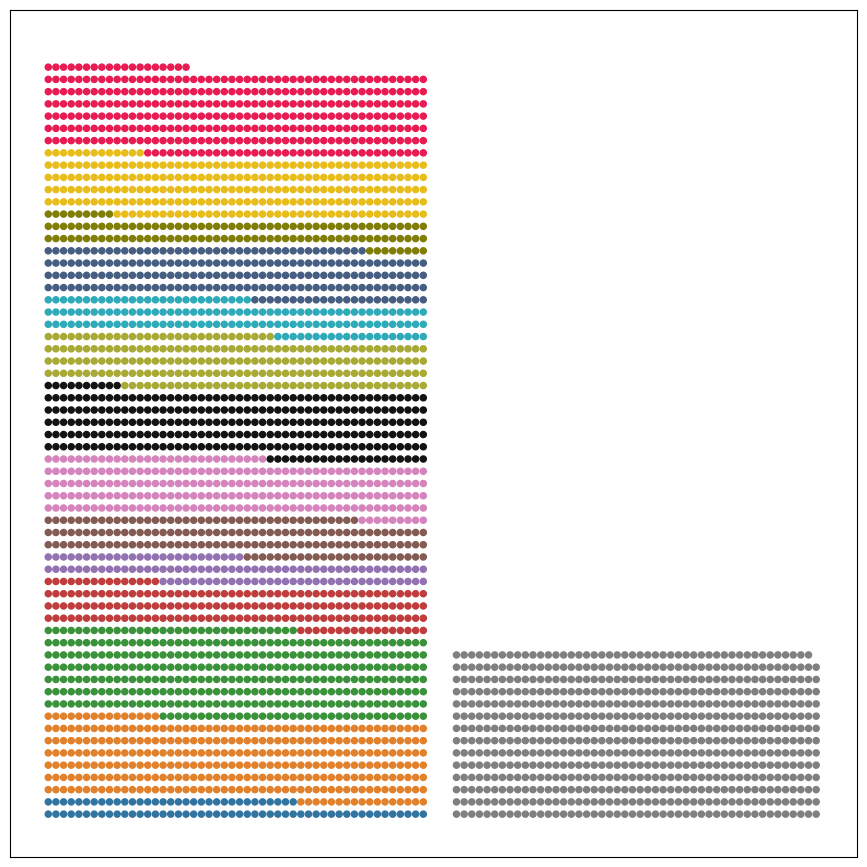

In [13]:
fig, ax = plt.subplots(figsize=(11, 11))

for i, color in enumerate(sorted(cluster.labels_)):
    #print(positions[i])
    circle = plt.Circle(positions[i], 0.3, color=color_map[color])
    ax.add_patch(circle)


for i in range(to_add):
    #print(unknown_positions[i])
    circle = plt.Circle(unknown_positions[i], 0.3, color="grey")
    ax.add_patch(circle)


# Set axis limits and aspect ratio
plt.axis('scaled')
ax.set_xlim((-3, 80))
ax.set_ylim((-3, 80))
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.savefig("Known_vs_Unknown_Qs.png", transparent=True)
